In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision as tv
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import glob
from PIL import Image
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

In [2]:
class STLDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""

    def __init__(self, df, transform=None):
        self.file_paths = df.img.values
        self.labels = df.y.values
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        image = Image.open(file_path)

        if self.transform:
            image = self.transform(image)

        return image, label, file_path

In [55]:
root_path = '.\\input\\train\\'

df_train = pd.DataFrame()
files = glob.glob(root_path + '**\\*.png', recursive=True)

df_train['img'] = [f for f in files]
df_train['y'] = [int(f.split('\\')[-2]) - 1 for f in df_train.img]

In [56]:
root_path = '.\\input\\test\\'

df_test = pd.DataFrame()
files = glob.glob(root_path + '**\\*.png', recursive=True)

df_test['img'] = [f for f in files]
df_test['y'] = [int(f.split('\\')[-2]) - 1 for f in df_test.img]



In [57]:
train_transform = transforms.Compose([
    # transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.45),
    transforms.RandomVerticalFlip(p=0.45),
    # transforms.RandomGrayscale(p=0.15),
    # transforms.ColorJitter(brightness=0.8, contrast=1.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

test_transform = transforms.Compose([
    # transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [141]:
num_workers = 0
batch_size = 32

train_dataset = STLDataset(df_train, transform=train_transform)
valid_dataset = STLDataset(df_test, transform=test_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [167]:
train_dataset = STLDataset(df_train3, transform=train_transform)


trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

        cat        deer         cat       truck


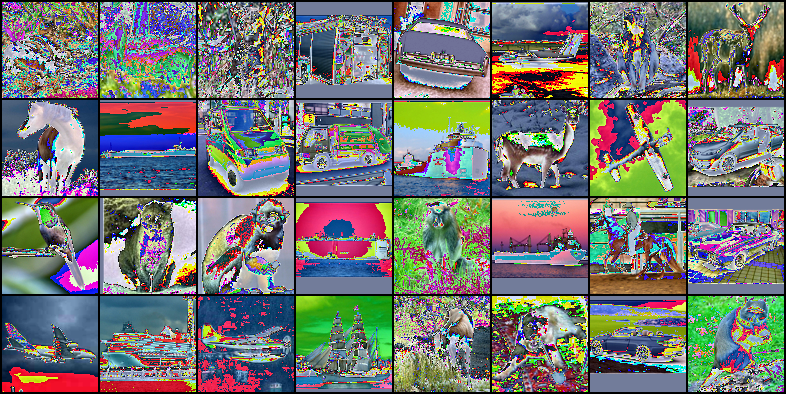

In [44]:
dataiter = iter(trainloader)
images, labels, _ = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'% classes[labels[j]-1] for j in range(4)))
show(tv.utils.make_grid((images+1)/2))

In [168]:
# model = tv.models.vgg16_bn(pretrained='ImageNet')
model = tv.models.vgg16_bn()
model.classifier = nn.Sequential(
    nn.Linear(in_features=4608, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=10, bias=True),
  )
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [60]:
def train(net, epoch):

    net.train()
    
    losses = 0
    for batch_index, (images, labels, _) in enumerate(trainloader):

        images = Variable(images)
        labels = Variable(labels)

        labels = labels.cuda()
        images = images.cuda()

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        trained_samples = batch_index * batch_size + len(images)
        losses += loss.item()
    
    print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
                losses / trained_samples,
                optimizer.param_groups[0]['lr'],
                epoch=epoch,
                trained_samples=trained_samples,
                total_samples=len(trainloader.dataset)
            ))

def valid(net, epoch):
    net.eval()

    test_loss = 0.0 # cost function error
    correct = 0.0

    for (images, labels, _) in validloader:
        images = Variable(images)
        labels = Variable(labels)

        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum()

    print('Test set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(
        test_loss / len(validloader.dataset),
        correct.float() / len(validloader.dataset)
    ))
    print()

    #add informations to tensorboard
    #writer.add_scalar('Test/Average loss', test_loss / len(cifar100_test_loader.dataset), epoch)
    #writer.add_scalar('Test/Accuracy', correct.float() / len(cifar100_test_loader.dataset), epoch)

    return correct.float() / len(validloader.dataset)


In [ ]:
lr = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

EPOCH = 300 #约在45-60之间收敛完毕
net_type = 'vgg16_bn'
best_acc = 0.0
for epoch in range(1, EPOCH):

    train(model, epoch)
    acc = valid(model, epoch)

    #start to save best performance model after learning rate decay to 0.01 
    if best_acc < acc:
        best_acc = acc
        patient = 0
        torch.save(model.state_dict(), './models/{}_{}_{}.pth'.format(net_type, epoch, best_acc))

print('best_acc: ', best_acc, ', epoch: ', epoch)


Training Epoch: 1 [10000/10000]	Loss: 0.0512	LR: 0.001000
Test set: Average loss: 0.0560, Accuracy: 0.3528

Training Epoch: 2 [10000/10000]	Loss: 0.0364	LR: 0.001000
Test set: Average loss: 0.0449, Accuracy: 0.4929

Training Epoch: 3 [10000/10000]	Loss: 0.0295	LR: 0.001000
Test set: Average loss: 0.0413, Accuracy: 0.5452

Training Epoch: 4 [10000/10000]	Loss: 0.0260	LR: 0.001000
Test set: Average loss: 0.0403, Accuracy: 0.5592

Training Epoch: 5 [10000/10000]	Loss: 0.0225	LR: 0.001000
Test set: Average loss: 0.0351, Accuracy: 0.6065

Training Epoch: 6 [10000/10000]	Loss: 0.0201	LR: 0.001000
Test set: Average loss: 0.0326, Accuracy: 0.6393

Training Epoch: 7 [10000/10000]	Loss: 0.0186	LR: 0.001000
Test set: Average loss: 0.0342, Accuracy: 0.6250

Training Epoch: 8 [10000/10000]	Loss: 0.0170	LR: 0.001000
Test set: Average loss: 0.0369, Accuracy: 0.6086

Training Epoch: 9 [10000/10000]	Loss: 0.0154	LR: 0.001000
Test set: Average loss: 0.0331, Accuracy: 0.6373

Training Epoch: 10 [10000/10

Training Epoch: 76 [10000/10000]	Loss: 0.0002	LR: 0.001000
Test set: Average loss: 0.0488, Accuracy: 0.7171

Training Epoch: 77 [10000/10000]	Loss: 0.0002	LR: 0.001000
Test set: Average loss: 0.0477, Accuracy: 0.7225

Training Epoch: 78 [10000/10000]	Loss: 0.0004	LR: 0.001000
Test set: Average loss: 0.0512, Accuracy: 0.7041

Training Epoch: 79 [10000/10000]	Loss: 0.0003	LR: 0.001000
Test set: Average loss: 0.0500, Accuracy: 0.7096

Training Epoch: 80 [10000/10000]	Loss: 0.0003	LR: 0.001000
Test set: Average loss: 0.0462, Accuracy: 0.7209

Training Epoch: 81 [10000/10000]	Loss: 0.0002	LR: 0.001000
Test set: Average loss: 0.0455, Accuracy: 0.7271

Training Epoch: 82 [10000/10000]	Loss: 0.0002	LR: 0.001000
Test set: Average loss: 0.0475, Accuracy: 0.7236

Training Epoch: 83 [10000/10000]	Loss: 0.0002	LR: 0.001000
Test set: Average loss: 0.0521, Accuracy: 0.7100

Training Epoch: 84 [10000/10000]	Loss: 0.0003	LR: 0.001000
Test set: Average loss: 0.0512, Accuracy: 0.7161

Training Epoch: 85 

Test set: Average loss: 0.0419, Accuracy: 0.7433

Training Epoch: 151 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0418, Accuracy: 0.7446

Training Epoch: 152 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0415, Accuracy: 0.7465

Training Epoch: 153 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0412, Accuracy: 0.7460

Training Epoch: 154 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0412, Accuracy: 0.7453

Training Epoch: 155 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0413, Accuracy: 0.7464

Training Epoch: 156 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0412, Accuracy: 0.7444

Training Epoch: 157 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0418, Accuracy: 0.7433

Training Epoch: 158 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0409, Accuracy: 0.7430

Training Epoch: 159 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: 

Training Epoch: 225 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0362, Accuracy: 0.7471

Training Epoch: 226 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0360, Accuracy: 0.7469

Training Epoch: 227 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0358, Accuracy: 0.7479

Training Epoch: 228 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0357, Accuracy: 0.7458

Training Epoch: 229 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0355, Accuracy: 0.7466

Training Epoch: 230 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0358, Accuracy: 0.7478

Training Epoch: 231 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0356, Accuracy: 0.7460

Training Epoch: 232 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0356, Accuracy: 0.7476

Training Epoch: 233 [10000/10000]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0353, Accuracy: 0.7501

Training E

In [62]:
classes = ('airplane', 'bird', 'car', 'cat','deer', 
           'dog', 'horse', 'monkey', 'ship', 'truck')

In [151]:
num_workers = 0
batch_size = 32

root_path = '.\\input\\unlabeled\\'

df_unlabeled = pd.DataFrame()
files = glob.glob(root_path + '**\\*.png', recursive=True)

df_unlabeled['img'] = [f for f in files]
df_unlabeled['y'] = 0

unlabeled_dataset = STLDataset(df_unlabeled, transform=test_transform)

unlabeledloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

预测结果:    dog   car airplane truck horse  bird  deer   cat  bird   cat   dog airplane   dog truck horse  bird horse truck  ship truck  ship airplane airplane monkey truck  deer horse  bird monkey   dog airplane truck


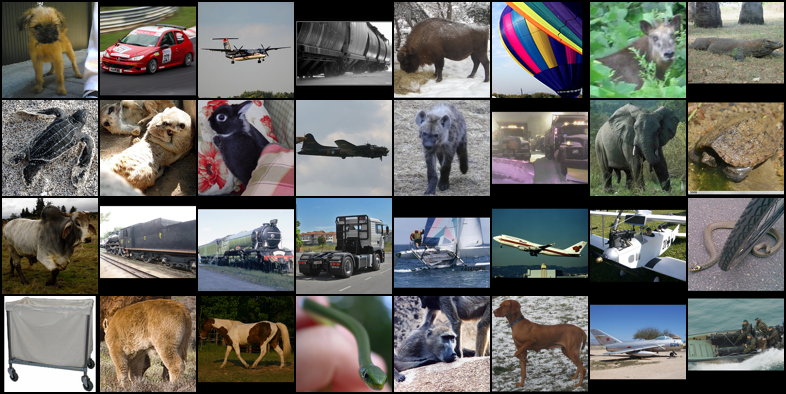

In [65]:
dataiter = iter(unlabeledloader)
images, labels, filenames = dataiter.next() # 返回4张图片及标签

#print(' '.join('%11s'% classes[labels[j]-1] for j in range(32)))


imgs = None
for f in filenames:
    img = np.array(Image.open(f))
    if(imgs is None):
        imgs = np.concatenate([img.reshape(1, 96, 96, 3).transpose(0, 3, 1, 2)])
    else:
        imgs = np.concatenate([imgs, img.reshape(1, 96, 96, 3).transpose(0, 3, 1, 2)])

# 计算图片在每个类别上的分数
outputs = model(images.cuda())
# 得分最高的那个类
_, predicted = torch.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(32)))

show(tv.utils.make_grid((torch.tensor(imgs))))

In [142]:
preds = outputs.softmax(dim=1)
preds

tensor([[9.9961e-01, 2.9677e-05, 1.1552e-06, 2.5966e-04, 1.3327e-05, 3.5652e-05,
         4.0282e-05, 6.0261e-07, 2.1111e-07, 9.0261e-06],
        [7.0001e-02, 4.2006e-05, 2.6043e-05, 3.2616e-05, 6.1070e-05, 1.2866e-05,
         3.8565e-05, 3.4814e-05, 4.0013e-05, 9.2971e-01],
        [2.4962e-01, 9.3613e-02, 3.9945e-03, 1.7398e-03, 6.2572e-04, 8.8721e-02,
         5.0688e-03, 5.4878e-01, 1.6836e-03, 6.1516e-03],
        [3.7656e-02, 8.0500e-04, 9.0468e-05, 1.9200e-04, 1.4544e-04, 7.2605e-05,
         1.6591e-04, 1.1931e-04, 1.0486e-04, 9.6065e-01],
        [6.2795e-01, 3.8272e-03, 1.9017e-03, 3.5400e-01, 4.9115e-05, 3.2448e-04,
         8.7398e-03, 2.6762e-03, 2.6553e-04, 2.6157e-04],
        [9.4944e-02, 9.9071e-04, 3.0320e-04, 2.8449e-04, 2.0660e-04, 1.9637e-04,
         2.3195e-04, 2.2622e-04, 1.6846e-04, 9.0245e-01],
        [1.4184e-01, 8.5785e-01, 5.8323e-06, 8.7596e-05, 6.1666e-07, 4.6969e-06,
         2.1320e-06, 7.2199e-05, 8.1724e-06, 1.3165e-04],
        [1.4269e-01, 3.0910

In [66]:
def predict(net, dataloader):
    net.eval()

    test_loss = 0.0 # cost function error
    correct = 0.0
    
    preds = None
    
    filelist = []

    for (images, labels, filenames) in dataloader:
        filelist += filenames
        
        images = Variable(images)
        labels = Variable(labels)

        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        
        p = outputs.softmax(dim=1).cpu().data.numpy()

        if (preds is None):
            preds = np.concatenate([p])
        else:
            preds = np.concatenate([preds, p])
        

    #add informations to tensorboard
    #writer.add_scalar('Test/Average loss', test_loss / len(cifar100_test_loader.dataset), epoch)
    #writer.add_scalar('Test/Accuracy', correct.float() / len(cifar100_test_loader.dataset), epoch)

    return preds, filelist

In [150]:
PATH = './models/vgg16_bn_55_0.9376250505447388.pth' 
# 学习率为0.001， 优化器为SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)， 

PATH = './models/vgg16_bn_61_0.9360000491142273.pth' 
# 增加 unlabeled 数据中挑选出分类概论为 1.0 的样本
# 学习率为0.001， 优化器为SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)， 

PATH = './models/vgg16_bn_149_0.7361250519752502.pth'

model.load_state_dict(torch.load(PATH))
model.cuda().eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [152]:
preds, filelist = predict(model, unlabeledloader)

In [153]:
df_preds = pd.DataFrame(data=preds)

df_preds['img'] = filelist
df_preds['y'] = preds.argmax(axis=1)

In [154]:
# df_preds['y'] -= 2
df_preds['p'] = preds.max(axis=1)


df_preds.head(32)

,0,1,2,3,4,5,6,7,8,9,img,y,p
0,6.566155e-11,1.292109e-08,3.160459e-08,9.788517e-05,7.297582e-13,4.932645e-08,1.903499e-09,2.393621e-11,2.530962e-05,9.998767e-01,.\input\unlabeled\69133.png,9,0.999877
1,2.937533e-08,3.118185e-08,4.197885e-10,1.610234e-04,6.995114e-11,5.968974e-03,4.530257e-02,9.485672e-01,2.789564e-07,3.176097e-08,.\input\unlabeled\86895.png,7,0.948567
2,3.235539e-10,1.368892e-07,9.999968e-01,1.673684e-07,3.707032e-10,8.294990e-13,4.562200e-09,5.287215e-11,1.809436e-06,1.146969e-06,.\input\unlabeled\49521.png,2,0.999997
3,9.973563e-01,3.386770e-09,2.236534e-05,9.154749e-09,1.574502e-09,1.515479e-11,2.698320e-09,6.975710e-12,8.060155e-05,2.540811e-03,.\input\unlabeled\72886.png,0,0.997356
4,1.904989e-09,1.648056e-05,2.702429e-12,4.771424e-06,7.686542e-09,9.999458e-01,1.133841e-08,3.298936e-05,1.507195e-09,1.204263e-09,.\input\unlabeled\40224.png,5,0.999946
5,2.742792e-03,4.004242e-01,7.706176e-02,2.618709e-04,7.266217e-02,1.397892e-02,3.021919e-01,3.328768e-04,1.264486e-01,3.894875e-03,.\input\unlabeled\95452.png,1,0.400424
6,2.337107e-07,2.500399e-03,2.963364e-08,6.142327e-03,9.911725e-01,2.789242e-05,7.466233e-06,1.219944e-04,2.670863e-05,6.088293e-07,.\input\unlabeled\96658.png,4,0.991172
7,3.949041e-07,2.749051e-01,6.650264e-09,7.250382e-01,3.943996e-08,4.952657e-08,4.740933e-09,2.482959e-05,3.082455e-05,5.510598e-07,.\input\unlabeled\12399.png,3,0.725038
8,2.856235e-05,1.152560e-04,2.406012e-09,2.488381e-02,1.551032e-04,9.710297e-01,1.607335e-04,3.626450e-03,1.444273e-07,2.409006e-07,.\input\unlabeled\56632.png,5,0.971030
9,8.169802e-03,9.916653e-01,2.499739e-09,3.124819e-06,1.580747e-04,1.230037e-06,4.769903e-08,1.543883e-08,2.294659e-06,4.016997e-07,.\input\unlabeled\70289.png,1,0.991665


In [156]:
df_preds.to_csv('./df_preds.csv', index=False)

In [158]:
df_temp = df_preds[df_preds.p==1]
df_temp.shape

(5804, 13)

In [157]:
df_train2 = pd.concat([df_train, df_temp[['img', 'y']]])
df_train2.shape

(10804, 2)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


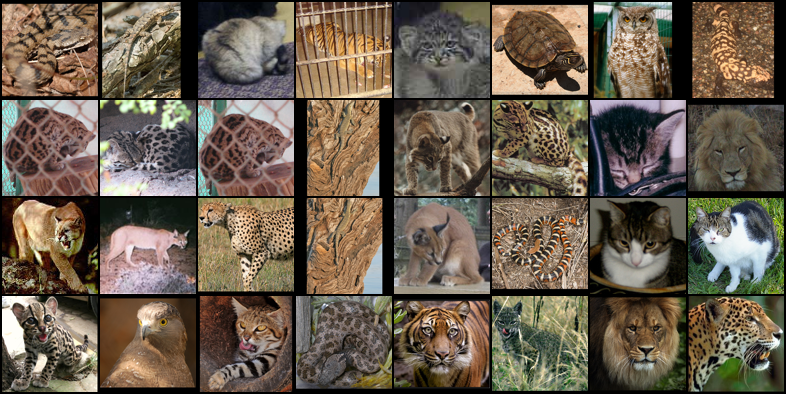

In [163]:
# img = Image.open(df_preds.iloc[0].filelist)

df_temp2 = df_temp[df_temp.y==3]
imgs = None

ylist = []
plist = []
for i in range(32):
    raw = df_temp2.iloc[i]
    # raw = df_preds.iloc[i]
    img = np.array(Image.open(raw.img))
    if(imgs is None):
        imgs = np.concatenate([img.reshape(1, 96, 96, 3).transpose(0, 3, 1, 2)])
    else:
        imgs = np.concatenate([imgs, img.reshape(1, 96, 96, 3).transpose(0, 3, 1, 2)])
        
    ylist.append(classes[9 if raw.y == -1 else raw.y])  
    plist.append(raw.p)

print(plist)
show(tv.utils.make_grid((torch.tensor(imgs))))


In [161]:
for i, g in df_temp.groupby('y'):
    print(classes[i], g.shape)

airplane (789, 13)
bird (224, 13)
car (886, 13)
cat (126, 13)
deer (376, 13)
dog (123, 13)
horse (737, 13)
monkey (269, 13)
ship (1407, 13)
truck (867, 13)


In [164]:
df_train3 = None
for i in range(10):
    
    df_tmp = df_preds[df_preds.y==i].sort_values('p', ascending=False).iloc[:500].copy()
    if(df_train3 is None):
        df_train3 = df_tmp
    else:
        df_train3 = pd.concat([df_train3, df_tmp])
    

In [166]:

# df_train3 = pd.concat([df_train3[['img', 'y']], df_train])
df_train3.shape

(10000, 2)

In [135]:
df_train.shape

(5000, 2)